In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = InteractiveSession(config=config)

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
tf.__version__

'2.0.0'

In [2]:
"""Load the data and reshape to feed into CNN"""

train_data = np.array(pickle.load(open('data/SR-ARE-train/names_onehots.pickle', 'rb'))['onehots']).reshape(-1,70,325,1)
test_data = np.array(pickle.load(open('data/SR-ARE-test/names_onehots.pickle', 'rb'))['onehots']).reshape(-1,70,325,1)

print('Training data shape:', train_data.shape)
print('Testing data shape:', test_data.shape)


Training data shape: (7167, 70, 325, 1)
Testing data shape: (234, 70, 325, 1)


In [3]:
"""Get labels of each corresponding training and testing one hot vectors"""

def get_labels(file_path):
    with open(file_path, 'r') as f:
        labels = [int(line.rstrip().split(',')[-1]) for line in f]
        f.close()
    return labels

train_labels = np.array(get_labels('data/SR-ARE-train/names_labels.txt'))
test_labels = np.array(get_labels('data/SR-ARE-test/names_labels.txt'))

print('Training labels shape:', train_labels.shape)
print('Testing labels shape:', test_labels.shape)

Training labels shape: (7167,)
Testing labels shape: (234,)


In [4]:
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall')]

def CNN(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)

    model = keras.models.Sequential([
        keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=train_data.shape[1:]),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(32, (3,3), activation='relu'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.RMSprop(lr=0.001),
                  metrics=metrics)
    return model

initial_bias = np.log(1098/6069)
model = CNN(output_bias=initial_bias)

Train on 7167 samples
Epoch 1/20
7167/7167 [==============================] - 36s 5ms/sample - loss: 0.4903 - tp: 3.0000 - fp: 11.0000 - tn: 6058.0000 - fn: 1095.0000 - accuracy: 0.8457 - precision: 0.2143 - recall: 0.0027
Epoch 2/20
7167/7167 [==============================] - 28s 4ms/sample - loss: 0.4428 - tp: 4.0000 - fp: 3.0000 - tn: 6066.0000 - fn: 1094.0000 - accuracy: 0.8469 - precision: 0.5714 - recall: 0.0036
Epoch 3/20
7167/7167 [==============================] - 28s 4ms/sample - loss: 0.4379 - tp: 2.0000 - fp: 3.0000 - tn: 6066.0000 - fn: 1096.0000 - accuracy: 0.8467 - precision: 0.4000 - recall: 0.0018
Epoch 4/20
7167/7167 [==============================] - 28s 4ms/sample - loss: 0.4358 - tp: 1.0000 - fp: 1.0000 - tn: 6068.0000 - fn: 1097.0000 - accuracy: 0.8468 - precision: 0.5000 - recall: 9.1075e-04
Epoch 5/20
7167/7167 [==============================] - 28s 4ms/sample - loss: 0.4327 - tp: 3.0000 - fp: 7.0000 - tn: 6062.0000 - fn: 1095.0000 - accuracy: 0.8462 - precisio

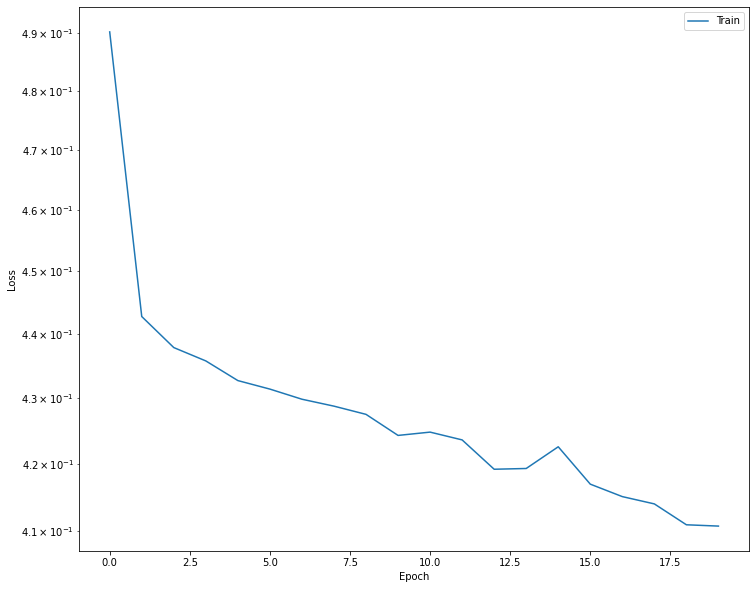

In [5]:
def plot_loss(history, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train')
    # plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val' , linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    return plt.show()

model_history = model.fit(train_data, train_labels, epochs=20, verbose=1)
plot_loss(model_history, 0)

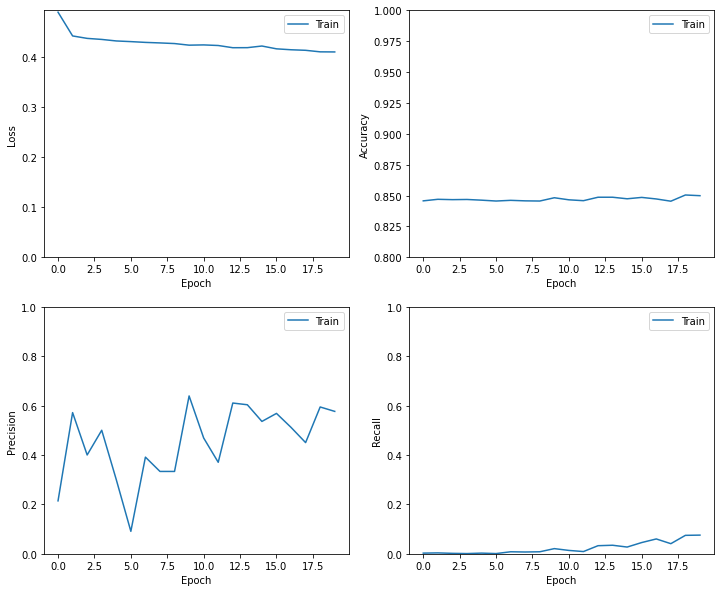

In [6]:
def plot_metrics(history):
  metrics =  ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    # plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_history)